In [1]:
# Load corpus directory
import os
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [2]:
def load_corpus(path_to_dir: str, start_idx: int = 0, end_idx: int = -1) -> np.array:
    """Load corpus from directory"""
    path_to_dir = os.path.abspath(path_to_dir)
    corpus, authors, titles = [], [], []
    for filename in os.listdir(path_to_dir):
        author, _ = os.path.splitext(os.path.basename(filename))

        with open(os.path.join(path_to_dir, filename), 'r', encoding='utf-8') as f:
            contents = f.read()
        lemmas = contents.lower().split()

        corpus.append(' '.join(lemmas[start_idx:end_idx]))
        authors.append(author[0])
        # title = filename.replace('.txt', '').split('_')[1]
        file_count = filename.replace('.txt', '').split('_')[-1]
        titles.append(file_count)

    return corpus, authors, titles

In [3]:
corpus, authors, titles = load_corpus('../data/corpus')
print(f"Corpus:{len(corpus):>6}")
print(f"Authors:{len(authors):>5}")
print(f"Titles:{len(titles):>6}")

Corpus:  1292
Authors: 1292
Titles:  1292


In [4]:
print(corpus[0][:100])
print(authors[:5], authors[-5:])
print(titles[:5], titles[-5:])

14 απριλίου 2022 η επιθετικότητα της ρωσίας στην ουκρανία προκαλεί τεράστια δεινά. επηρεάζει επίσης 
['g', 'g', 'g', 'g', 'g'] ['h', 'h', 'h', 'h', 'h']
['001', '002', '003', '004', '005'] ['642', '643', '644', '645', '646']


In [5]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(max_features=1000, analyzer='word', ngram_range=(2, 4))

v_documents = vect.fit_transform(corpus).toarray()

print(v_documents.shape)

(1292, 1000)


In [6]:
from sklearn.preprocessing import normalize

v_documents = normalize(v_documents.astype(float), norm='l1')
v_documents

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.004     ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00335008],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [7]:
scl = StandardScaler()

s_documents = scl.fit_transform(v_documents)
s_documents.shape

(1292, 1000)

In [8]:
from sklearn.model_selection import train_test_split

(train_documents, test_documents, train_authors, test_authors) = train_test_split(
    v_documents,  # dataset for split
    authors,      # dataset for split
    test_size=.2, # size of testing dataset
    stratify=authors, # preserve the proportion of classes in train and test as in the original dataset
    random_state=97) # perform split according to this 'state'

print(f'{test_documents.shape[0]} test documents with '
      f'{test_documents.shape[1]} features.')

print(f'{train_documents.shape[0]} train documents with '
      f'{train_documents.shape[1]} features.')

print(train_authors)
print(test_authors)

259 test documents with 1000 features.
1033 train documents with 1000 features.
['g', 'g', 'g', 'g', 'h', 'h', 'g', 'g', 'g', 'g', 'h', 'h', 'g', 'g', 'h', 'h', 'g', 'h', 'h', 'g', 'h', 'g', 'h', 'h', 'h', 'g', 'g', 'g', 'g', 'h', 'g', 'g', 'h', 'h', 'g', 'g', 'h', 'g', 'h', 'g', 'g', 'g', 'h', 'h', 'g', 'g', 'h', 'g', 'g', 'g', 'g', 'g', 'g', 'h', 'g', 'h', 'g', 'h', 'g', 'h', 'g', 'h', 'h', 'h', 'g', 'h', 'h', 'g', 'g', 'h', 'h', 'g', 'h', 'g', 'h', 'g', 'h', 'g', 'h', 'h', 'g', 'h', 'h', 'h', 'h', 'g', 'g', 'g', 'h', 'g', 'h', 'h', 'h', 'h', 'h', 'h', 'g', 'g', 'g', 'h', 'h', 'g', 'g', 'g', 'h', 'g', 'h', 'h', 'h', 'h', 'g', 'h', 'h', 'h', 'g', 'h', 'h', 'h', 'g', 'h', 'g', 'g', 'g', 'h', 'g', 'g', 'h', 'h', 'g', 'h', 'g', 'h', 'h', 'g', 'h', 'g', 'g', 'g', 'g', 'g', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'g', 'h', 'g', 'g', 'g', 'g', 'g', 'h', 'g', 'h', 'h', 'h', 'h', 'h', 'h', 'g', 'g', 'h', 'h', 'h', 'g', 'h', 'h', 'g', 'h', 'h', 'g', 'g', 'h', 'g', 'g', 'h', 'h', 'h', 'g', 'h', 'h',

In [9]:
scl = StandardScaler()

scl.fit(train_documents)

train_documents = scl.transform(train_documents)
test_documents = scl.transform(test_documents)

In [10]:
from scipy.spatial import distance as scidist

distances = scidist.cdist(test_documents, train_documents, metric='cosine')

preds = np.array(train_authors)[np.argmin(distances, axis=1)]
print(preds[:6])

['h' 'h' 'h' 'h' 'h' 'g']


In [11]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(preds, test_authors)
print(f"Accuracy of predictions: {accuracy:.2f}")

Accuracy of predictions: 0.73


### HCA

In [12]:
from scipy.cluster import hierarchy

# 1. Calculate pairwise distances
dm = scidist.pdist(v_documents, 'cosine')

# 2. Establish branch structure (linkage_object, linking the most similar texts)
linkage_object = hierarchy.linkage(dm, method='complete')

# 3. Visualize
def plot_tree(linkage_object, labels, figsize=(20, 500), ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    with plt.rc_context({'lines.linewidth': 1.0}):
        hierarchy.dendrogram(
            linkage_object, labels=labels, ax=ax,
            orientation='right',
            link_color_func=lambda c: 'black',
            leaf_font_size=10, leaf_rotation=90)
    # Remove ticks and spines
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.autoscale(enable=True) 
    for s in ax.spines.values():
        s.set_visible(False)

In [13]:
# plot_tree(linkage_object, authors)

## Principal Component Analysis (PCA)

In [14]:
# words = vect.get_feature_names()
# authors = np.array(authors)
# x = v_documents[:, words.index('αν')]
# y = v_documents[:, words.index('εάν')]

# fig, ax = plt.subplots()
# for author in set(authors):
#     ax.scatter(x[authors==author], y[authors==author], label=author)
# ax.set(xlabel='αν', ylabel='εάν')
# plt.legend();

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
documents_proj = pca.fit_transform(v_documents)

print(v_documents.shape)
print(documents_proj.shape)

(1292, 1000)
(1292, 2)


In [16]:
authors[int(len(authors) / 2):]

['h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h'

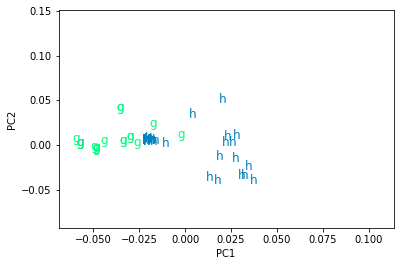

In [17]:
c1, c2 = documents_proj[:, 0], documents_proj[:, 1]

fig, ax = plt.subplots()
ax.scatter(c1, c2, facecolors='none') # empty plot but we need it

for p1, p2, author in zip(c1[625:675], c2[625:675], authors[625:675]):
    ax.text(p1, p2, author[0], fontsize=12, ha='center', va='center',
            color='#00ff80' if author[0] == 'g' else '#0080bf'
    )

ax.set(xlabel='PC1', ylabel='PC2');

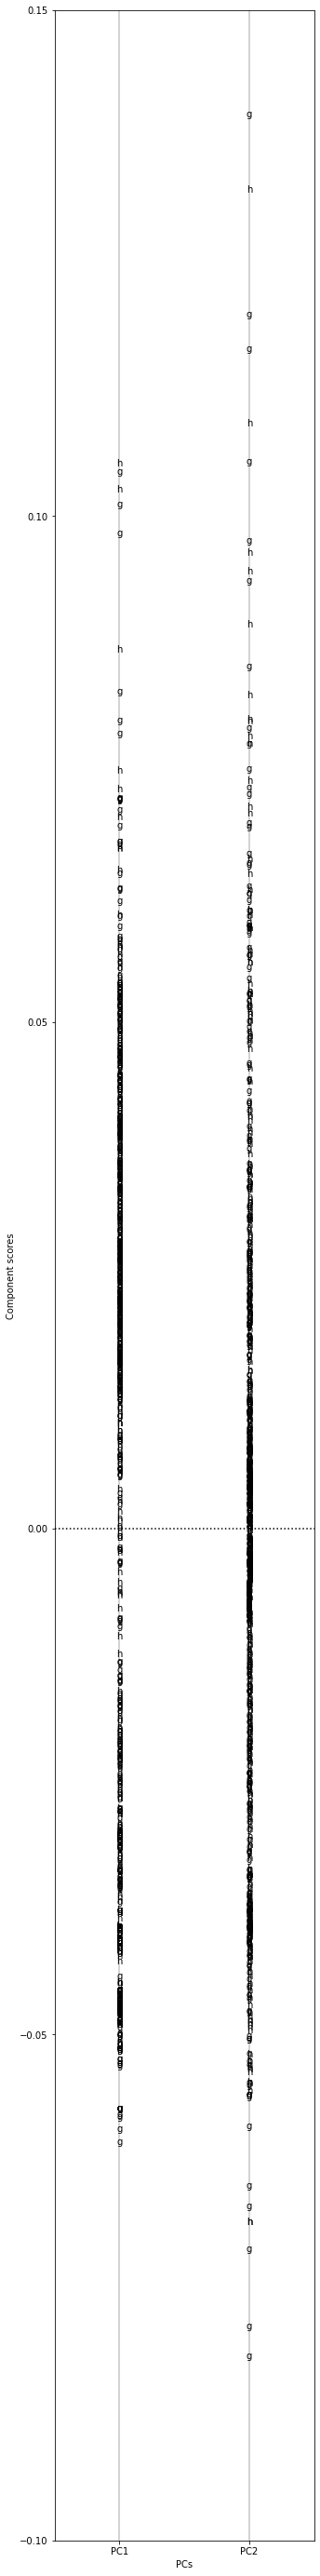

In [18]:
fig, ax = plt.subplots(figsize=(5, 50))

for idx in range(pca.components_.shape[0]):
    ax.axvline(idx, linewidth=2, color='lightgrey')
    for score, author in zip(documents_proj[:, idx], authors):
        ax.text(
            idx, score, author[0], fontsize=10,
            va='center', ha='center')

ax.axhline(0, ls='dotted', c='black')
ax.set(
    xlim=(-0.5, 1.5), ylim=(-0.1, 0.15),
    xlabel='PCs', ylabel='Component scores',
    xticks=[0, 1], xticklabels=['PC1', 'PC2']);

## t-Distributed Stohastic Neighboring Entities (t-SNE)

In [19]:
tsne = TSNE(n_components=2, perplexity=40, random_state=97, verbose=10)
tsne_proj = tsne.fit_transform(v_documents)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1292 samples in 0.003s...
[t-SNE] Computed neighbors for 1292 samples in 0.140s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1292
[t-SNE] Computed conditional probabilities for sample 1292 / 1292
[t-SNE] Mean sigma: 0.026184
[t-SNE] Computed conditional probabilities in 0.225s
[t-SNE] Iteration 50: error = 65.4654694, gradient norm = 0.1744368 (50 iterations in 2.186s)
[t-SNE] Iteration 100: error = 64.0637360, gradient norm = 0.1360900 (50 iterations in 1.245s)
[t-SNE] Iteration 150: error = 63.7330055, gradient norm = 0.1308938 (50 iterations in 1.140s)
[t-SNE] Iteration 200: error = 63.7383919, gradient norm = 0.1505761 (50 iterations in 1.495s)
[t-SNE] Iteration 250: error = 63.7186508, gradient norm = 0.1389742 (50 iterations in 1.069s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.718651
[t-SNE] Iteration 300: error = 0.7746910, gradient norm = 0.0010101 (50 iterations in 1.146s

In [20]:
import seaborn as sns

tsne_df = pd.DataFrame()
tsne_df['tSNE-1'] = tsne_proj[:,0]
tsne_df['tSNE-2'] = tsne_proj[:,1]
tsne_df['tSNE-2'] = tsne_df['tSNE-2'].apply(round)
tsne_df.sample(5)

,tSNE-1,tSNE-2
636,-64.298698,4
613,-61.593678,0
455,20.440481,-12
996,38.029160,-31
623,-17.243097,-22


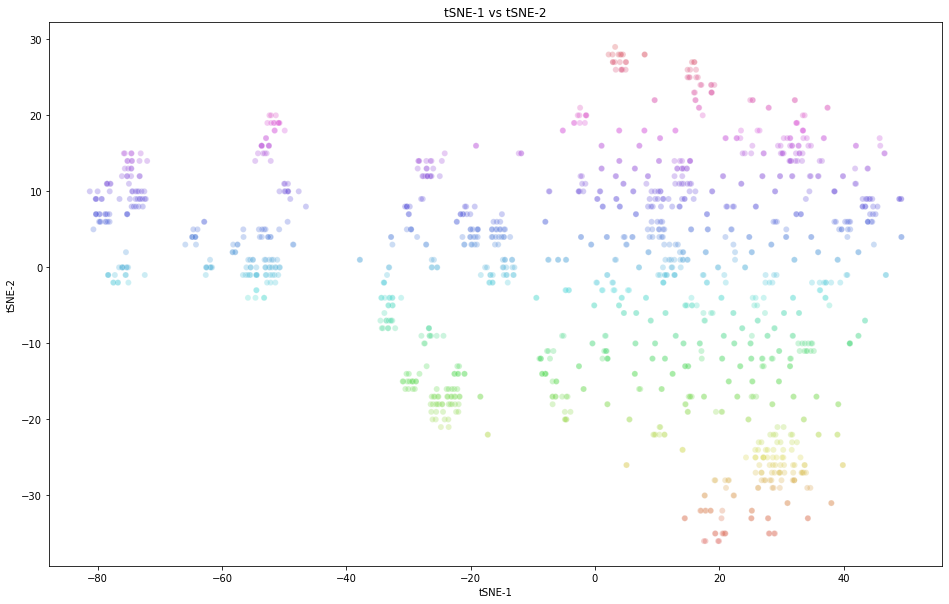

In [21]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='tSNE-1', y='tSNE-2',
    hue='tSNE-2',
    palette=sns.color_palette('hls', len(set(tsne_df['tSNE-2']))),
    data=tsne_df,
    legend=False,
    alpha=0.3
).set(title='tSNE-1 vs tSNE-2');